# Lista 4 - Redes Neurais Artificiais

<span style="position: absolute; top: 10px; right: 10px; background: green; padding: 0.5em; color: white; border-radius: 8px; font-weight: bold">Vaux Gomes</span>

### Importações


In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

### MinMax Normalizer

In [3]:
class MinMax():
    ''' MinMax Normalizer '''

    #
    def fit_transform(self, X):
        self.min = X.min(axis=0)
        self.max = X.max(axis=0)
        
        return (X - self.min)/(self.max - self.min)
    
    #
    def transform(self, X):
        return (X - self.min)/(self.max - self.min)
    
    #
    def restore(self, X):
        return X*(self.max - self.min) + self.min

### Rectified Linear Units Function (ReLU)

In [5]:
class ReLU():
    ''' Rectified Linear Units Function '''
    
    #
    def transfer(x): 
        ''' ReLU Function '''
        return x * (x > 0)
        
    #
    def derivative(x): 
        ''' Derivative '''
        return 1 * (x > 0)
    
    #
    def __str__():
        return 'ReLU'

### MLP

In [124]:
class MultilayerPerceptron:
    
    #
    def __init__(self, shape, epochs=300, batch_size=0.1, learning_rate=0.1, 
                 activation=ReLU, momentum=0.5, seed=42):
        #
        np.random.seed(seed)
        
        #
        self.shape = shape
        self.size = len(shape) - 1
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.activation = activation
        self.momentum = momentum
        
        #
        self.weights = []
        self.pwdelta = []
        
        #
        for (l1, l2) in zip(shape[:-1], shape[1:]):
            # print(l1, l2)
            self.weights.append(np.random.normal(scale=0.1, size=(l2, l1 + 1)))
            self.pwdelta.append(np.zeros((l2, l1 + 1)))

    #
    def fit(self, X, y, valid:tuple = None):        
        #
        self.errors = { 
            'train': { 'rmse': [], 'mae': [], 'mre': [] },
            'valid': { 'rmse': [], 'mae': [], 'mre': [] }}
        
        #
        indexes = np.arange(0, X.shape[0])
        
        #
        batch_size = int(self.batch_size * X.shape[0]) if type(self.batch_size) == float else self.batch_size
        batch_size = min(batch_size, X.shape[0])
        
        #
        print(f'Shape     : {self.shape}')
        print(f'Ephochs   : {self.epochs}')
        print(f'Batch Size: {batch_size}')
        
        # EPOCHS
        for e in range(self.epochs):
            #
            linputs  = [] # Layer input
            loutputs = [] # Layer output
            deltas   = []
            
            # Batch with replacement
            np.random.shuffle(indexes)
            
            X_batch = X[indexes[:batch_size]]
            y_batch = y[indexes[:batch_size]]
            
            #
            m, n = X_batch.shape

            # Forward        
            for idx in range(self.size):
                # First
                if idx == 0:
                    linput = self.weights[idx].dot(np.vstack([X_batch.T, np.ones([1, m])]))
                else:
                    linput = self.weights[idx].dot(np.vstack([linputs[-1], np.ones([1, m])]))

                #
                linputs.append(linput)
                loutputs.append(self.activation.transfer(linput))
                
            # Forward on validation
            if valid and len(valid) == 2:
                v_linput = valid[0]
                m_, _ = valid[0].shape
                
                for idx in range(self.size):
                    if idx == 0:
                        v_linput = self.weights[idx].dot(np.vstack([v_linput.T, np.ones([1, m_])]))
                    else:
                        v_linput = self.weights[idx].dot(np.vstack([v_linput, np.ones([1, m_])]))
                        
                    v_loutput = self.activation.transfer(v_linput)
                    
                # Error
                v_output_delta = v_loutput - valid[1].T
                
                # Validation errors
                self.errors['valid']['rmse'].append(np.sqrt((v_output_delta**2).mean()))
                self.errors['valid']['mae'].append(np.abs(v_output_delta).mean())
                self.errors['valid']['mre'].append(np.abs(v_output_delta/valid[1].T).mean())

            # Backward
            for idx in reversed(range(self.size)):
                # Last
                if idx == self.size - 1:
                    # Difference from the target
                    output_delta = loutputs[idx] - y_batch.T
                    deltas.append(output_delta * self.activation.derivative(linputs[idx]))
                    
                    # Train errors
                    self.errors['train']['rmse'].append(np.sqrt((output_delta**2).mean()))
                    self.errors['train']['mae'].append(np.abs(output_delta).mean())
                    self.errors['train']['mre'].append(np.abs(output_delta/y_batch.T).mean())
                    
                else:
                    # Difference from next layer's delta
                    delta_pullback = self.weights[idx + 1].T.dot(deltas[-1])
                    deltas.append(delta_pullback[:-1, :] * self.activation.derivative(linputs[idx]))               

            # Weight update
            for idx in range(self.size):
                delta_idx = self.size - 1 - idx
                
                # Input layer
                if idx == 0:
                    loutput = np.vstack([X_batch.T, np.ones([1, m])])
                else:
                    loutput = np.vstack([
                        loutputs[idx - 1], 
                        np.ones([1, loutputs[idx - 1].shape[1]])])
                    
                #   
                curr_wdelta = np.sum(
                    loutput[None, :, :].transpose(2, 0, 1) * 
                    deltas[delta_idx][None, :, :].transpose(2, 1, 0),
                    axis = 0
                )
                
                #
                wdelta = self.learning_rate * curr_wdelta + self.momentum * self.pwdelta[idx]
                
                # Update
                self.weights[idx] -= wdelta
                self.pwdelta[idx] = wdelta
            
    #
    def __repr__(self):
        return str(self.shape)

### Loading Concrete

In [181]:
# Importação dos conjuntos de dados
data = np.genfromtxt('concrete.csv', delimiter=',')

X = data[:, :-1]
y = data[:, -1:]

# [Train, Valid] + Test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=int(X.shape[0]*0.2), random_state=42)

# Normalizer
normalizer = MinMax()
#
X_train = normalizer.fit_transform(X_train)
X_test  = normalizer.transform(X_test) # Avoiding contamination

# Train + Valid already normalized
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=int(X.shape[0]*0.2), random_state=42)

print(f'Concrete: {X.shape}, {y.shape}')
print(f'   Train: {X_train.shape}, {y_train.shape}')
print(f'    Test: {X_test.shape }, {y_test.shape }')
print(f'   Valid: {X_valid.shape}, {y_valid.shape}')

Concrete: (1030, 8), (1030, 1)
   Train: (618, 8), (618, 1)
    Test: (206, 8), (206, 1)
   Valid: (206, 8), (206, 1)


#### FIT -- Train $\times$ Validation

Shape     : (8, 10, 1)
Ephochs   : 300
Batch Size: 16
(8, 10, 1)
--
ERROR TRAIN VALID
----------------------------------------------------------------------
  Train RMSE:  40.7579
  Train  MAE:  37.8612
  Train  MRE:   1.0000
--
  Valid RMSE:  39.7321
  Valid  MAE:  35.6891
  Valid  MRE:   1.0000
--


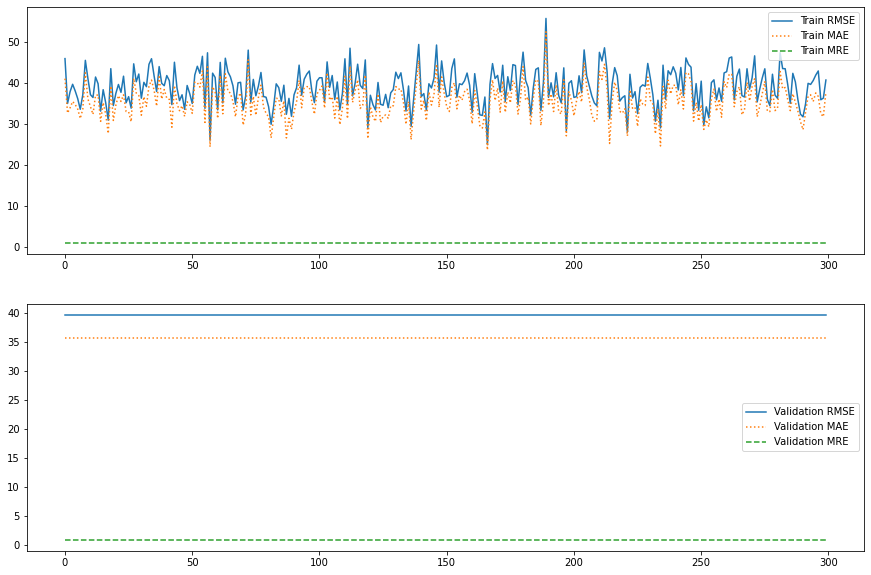

In [192]:
# MODEL
model = MultilayerPerceptron((X_train.shape[1], 10, 1), epochs=300, learning_rate=0.03, batch_size=2**4)
model.fit(X_train, y_train, (X_valid, y_valid))

#
print(model)

#
print('--\nError Train Valid'.upper())
print('-'*70)

for i in model.errors.keys():    
    for j in model.errors[i].keys():
        print(f'  {i.title()} {j.upper():>4}: {model.errors[i][j][-1]:>8.4f}')
        
    print('--')

# PLOT
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

_ = ax1.plot(model.errors['train']['rmse'], label="Train RMSE")
_ = ax1.plot(model.errors['train']['mae' ], ls='dotted', label="Train MAE" )
_ = ax1.plot(model.errors['train']['mre' ], ls='--', label="Train MRE" )

_ = ax2.plot(model.errors['valid']['rmse'], label="Validation RMSE")
_ = ax2.plot(model.errors['valid']['mae' ], ls='dotted', label="Validation MAE" )
_ = ax2.plot(model.errors['valid']['mre' ], ls='--', label="Validation MRE" )

# ax1.set_ylim((0, 10))
ax1.legend()

# ax2.set_ylim((0, 10))
ax2.legend()

#### FIT -- (Train + Validation) $\times$ Test

Shape     : (8, 10, 1)
Ephochs   : 300
Batch Size: 16
(8, 10, 1)
--
ERROR TRAIN VALID
----------------------------------------------------------------------
  Train RMSE:  35.5537
  Train  MAE:  33.4706
  Train  MRE:   1.0000
--
  Valid RMSE:  39.1049
  Valid  MAE:  35.6583
  Valid  MRE:   1.0000
--


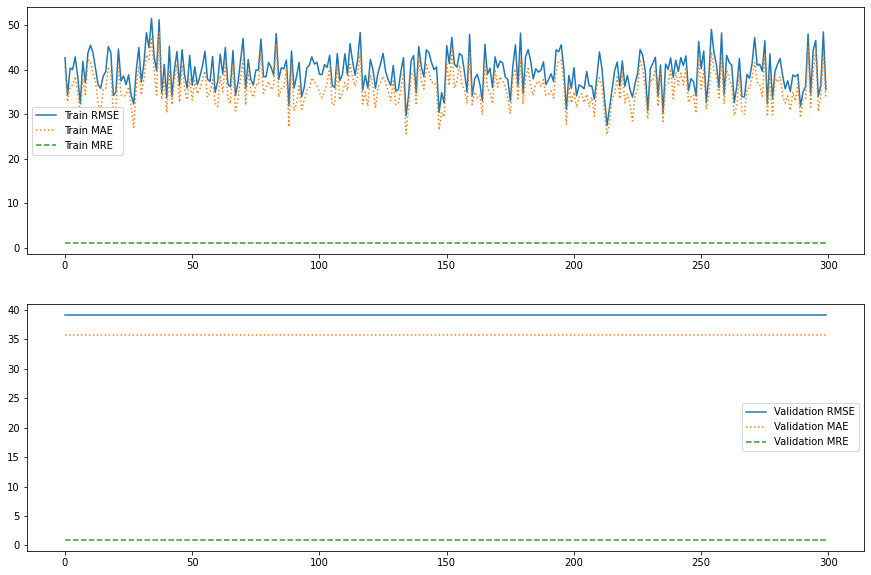

In [191]:
# MODEL: Fit train + valid x test
model2 = MultilayerPerceptron((X_train.shape[1], 10, 1), epochs=300, learning_rate=0.03, batch_size=2**4)
model2.fit(
    np.concatenate((X_train, X_valid), axis=0), 
    np.concatenate((y_train, y_valid), axis=0),
    (X_test, y_test)
)

#
print(model2)

#
print('--\nError Train Valid'.upper())
print('-'*70)

for i in model2.errors.keys():    
    for j in model2.errors[i].keys():
        print(f'  {i.title()} {j.upper():>4}: {model2.errors[i][j][-1]:>8.4f}')
        
    print('--')

# PLOT
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

_ = ax1.plot(model2.errors['train']['rmse'], label="Train RMSE")
_ = ax1.plot(model2.errors['train']['mae' ], ls='dotted', label="Train MAE" )
_ = ax1.plot(model2.errors['train']['mre' ], ls='--', label="Train MRE" )

_ = ax2.plot(model2.errors['valid']['rmse'], label="Validation RMSE")
_ = ax2.plot(model2.errors['valid']['mae' ], ls='dotted', label="Validation MAE" )
_ = ax2.plot(model2.errors['valid']['mre' ], ls='--', label="Validation MRE" )

# ax1.set_ylim((0, 100))
ax1.legend()

# ax2.set_ylim((20, 60))
ax2.legend()

### Loading Vowel

In [193]:
# Importação dos conjuntos de dados
data = np.genfromtxt('vowel.csv', delimiter=',')

X = data[:, :-1]
y = data[:, -1:]

#
c, d = np.unique(y, return_counts=True)
print(f'\nClass distribuition: {len(c)}')

for i in range(len(c)):
    print(f'{c[i]:>5}: {d[i]}')


Class distribuition: 11
  0.0: 90
  1.0: 90
  2.0: 90
  3.0: 90
  4.0: 90
  5.0: 90
  6.0: 90
  7.0: 90
  8.0: 90
  9.0: 90
 10.0: 90


In [194]:
y_encoded = np.zeros((y.size, int(y.max() + 1)))
y_encoded[np.arange(y.size), y.flatten().astype(int)] = 1

print('Y Encoded:')
print(y_encoded[:3])
print(y_encoded.shape)

Y Encoded:
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
(990, 11)


In [195]:
# [Train, Valid] + Test 
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=int(X.shape[0]*0.2), random_state=42)

# Normalizer
normalizer = MinMax()
#
X_train = normalizer.fit_transform(X_train)
X_test  = normalizer.transform(X_test) # Avoiding contamination

# Train + Valid already normalized
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=int(X.shape[0]*0.2), random_state=42)

print(f'Votes: {X.shape}, {y.shape}')
print(f'Train: {X_train.shape}, {y_train.shape}')
print(f' Test: {X_test.shape }, {y_test.shape }')
print(f'Valid: {X_valid.shape}, {y_valid.shape}')

Votes: (990, 10), (990, 1)
Train: (594, 10), (594, 11)
 Test: (198, 10), (198, 11)
Valid: (198, 10), (198, 11)


#### FIT -- Train $\times$ Validation

Shape     : (10, 12, 11)
Ephochs   : 300
Batch Size: 16
(10, 12, 11)
--
ERROR TRAIN VALID
----------------------------------------------------------------------
  Train RMSE:   0.2749
  Train  MAE:   0.1174
  Train  MRE:      nan
--
  Valid RMSE:   0.2687
  Valid  MAE:   0.1085
  Valid  MRE:      nan
--


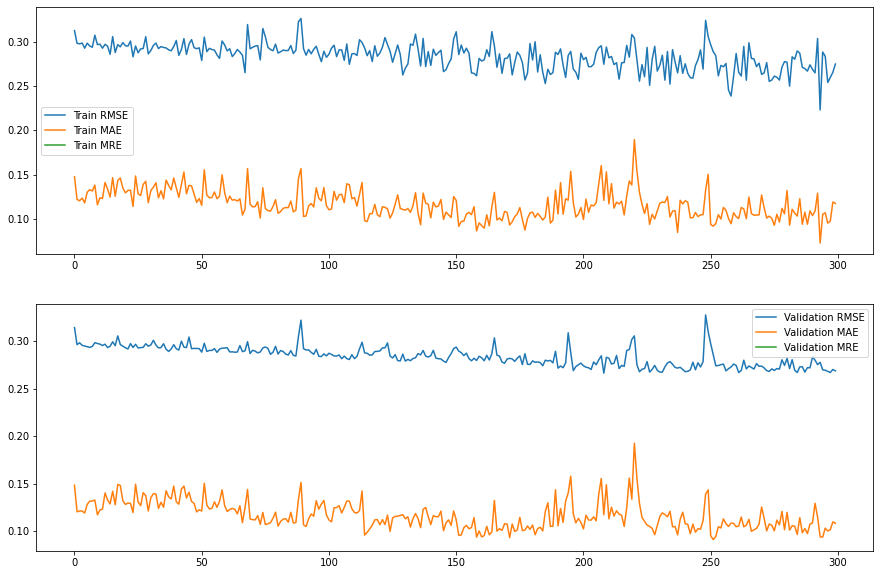

In [178]:
# MODEL
model = MultilayerPerceptron((X_train.shape[1], 12, y_train.shape[1]), epochs=300, learning_rate=0.05, momentum=0.1, batch_size=2**4)
model.fit(X_train, y_train, (X_valid, y_valid))
#
print(model)

#
print('--\nError Train Valid'.upper())
print('-'*70)

for i in model.errors.keys():    
    for j in model.errors[i].keys():
        print(f'  {i.title()} {j.upper():>4}: {model.errors[i][j][-1]:>8.4f}')
        
    print('--')

# PLOT
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

_ = ax1.plot(model.errors['train']['rmse'], label="Train RMSE")
_ = ax1.plot(model.errors['train']['mae' ], label="Train MAE" )
_ = ax1.plot(model.errors['train']['mre' ], label="Train MRE" )

_ = ax2.plot(model.errors['valid']['rmse'], label="Validation RMSE")
_ = ax2.plot(model.errors['valid']['mae' ], label="Validation MAE" )
_ = ax2.plot(model.errors['valid']['mre' ], label="Validation MRE" )

# ax1.set_ylim((0, 10))
ax1.legend()

# ax2.set_ylim((0, 10))
ax2.legend()

#### FIT -- (Train + Validation) $\times$ Test

Shape     : (10, 12, 1)
Ephochs   : 300
Batch Size: 16
(10, 12, 1)
--
ERROR TRAIN VALID
----------------------------------------------------------------------
  Train RMSE:   3.3824
  Train  MAE:   3.1359
  Train  MRE:   1.0854
--
  Valid RMSE:   3.1906
  Valid  MAE:   2.7390
  Valid  MRE:      inf
--


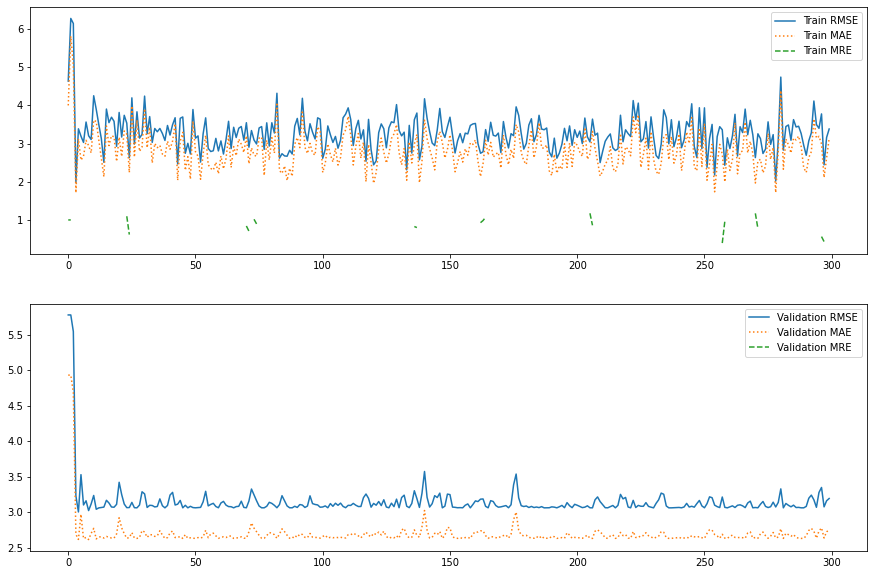

In [154]:
# MODEL: Fit train + valid x test
model2 = MultilayerPerceptron((X_train.shape[1], 12, 1), epochs=300, learning_rate=0.03, batch_size=2**4)
model2.fit(
    np.concatenate((X_train, X_valid), axis=0), 
    np.concatenate((y_train, y_valid), axis=0),
    (X_test, y_test)
)

#
print(model2)

#
print('--\nError Train Valid'.upper())
print('-'*70)

for i in model2.errors.keys():    
    for j in model2.errors[i].keys():
        print(f'  {i.title()} {j.upper():>4}: {model2.errors[i][j][-1]:>8.4f}')
        
    print('--')

# PLOT
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

_ = ax1.plot(model2.errors['train']['rmse'], label="Train RMSE")
_ = ax1.plot(model2.errors['train']['mae' ], ls='dotted', label="Train MAE" )
_ = ax1.plot(model2.errors['train']['mre' ], ls='--', label="Train MRE" )

_ = ax2.plot(model2.errors['valid']['rmse'], label="Validation RMSE")
_ = ax2.plot(model2.errors['valid']['mae' ], ls='dotted', label="Validation MAE" )
_ = ax2.plot(model2.errors['valid']['mre' ], ls='--', label="Validation MRE" )

# ax1.set_ylim((0, 100))
ax1.legend()

# ax2.set_ylim((20, 60))
ax2.legend()